In [3]:
import json
import webbrowser

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymoo.indicators.hv import Hypervolume

from enroads_runner import EnroadsRunner
from evolution.outcomes.outcome_manager import OutcomeManager
from generate_url import actions_to_url
from moo.problems.enroads_problem import EnroadsProblem

## Setup

In [4]:
save_path = "results/pymoo/novelty"
with open(save_path + "/config.json", 'r') as f:
    config = json.load(f)

actions = config["actions"]
outcomes = config["outcomes"]

with open(save_path + "/results", 'rb') as f:
    res = dill.load(f)
    print("Loaded Checkpoint:", res)

X = res.X
F = res.F

# NOTE: Don't use the problem to evaluate because we might run into concurrency issues with read/write.
problem = EnroadsProblem(actions, outcomes)
runner = EnroadsRunner("experiments/temp")
baseline_df = runner.evaluate_actions({})
outcome_manager = OutcomeManager(list(outcomes.keys()))
baseline_metrics = outcome_manager.process_outcomes({}, baseline_df)

Loaded Checkpoint: <pymoo.core.result.Result object at 0x1136623b0>
make: `enroads' is up to date.
make: `enroads' is up to date.


## Convergence Check

In [5]:
def extract_history(res, save_path=None):
    hist = res.history
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
    hist_cv = []             # constraint violation in each generation
    hist_cv_avg = []         # average constraint violation in the whole population
    for algo in hist:

        # store the number of function evaluations
        n_evals.append(algo.evaluator.n_eval)

        # retrieve the optimum from the algorithm
        opt = algo.opt

        # store the least contraint violation and the average in each population
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())

        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
    return n_evals, hist_F, hist_cv, hist_cv_avg

n_evals, hist_F, hist_cv, hist_cv_avg = extract_history(res)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

metric = Hypervolume(ref_point=approx_nadir+1,
                     norm_ref_point=True,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
if save_path:
    plt.savefig(save_path + "/convergence.png", dpi=300)
plt.show()

TypeError: object of type 'numpy.float64' has no len()

## Objectives

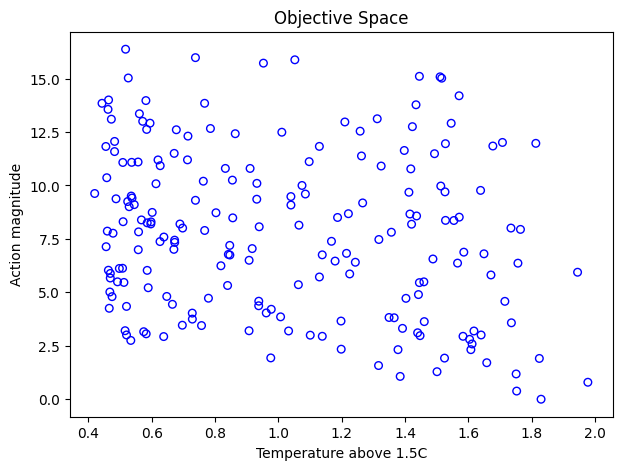

In [ ]:
obj_idxs = (0, 5)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, obj_idxs[0]], F[:, obj_idxs[1]], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel(list(outcomes.keys())[obj_idxs[0]])
plt.ylabel(list(outcomes.keys())[obj_idxs[1]])
plt.show()

In [ ]:
sample_idxs = set()
for i in range(F.shape[1]):
    sample_idxs.add(F[:,i].argmin())
    sample_idxs.add(F[:,i].argmax())

sample_idxs = list(sample_idxs)
print(sample_idxs)
print(F[sample_idxs])

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[[ 4.19880000e-01  9.57451000e+01  2.86902557e+01  2.08249320e+04
   2.56466224e-02  9.62346138e+00]
 [ 6.69980000e-01  4.22532000e+01  1.64265323e+02  1.25838890e+04
   2.11349827e-02  7.01083988e+00]
 [ 4.59760000e-01  1.16159000e+02  0.00000000e+00  2.04509410e+04
   3.16191369e-02  7.86341680e+00]
 [ 1.97749000e+00  2.28157000e+01  0.00000000e+00 -0.00000000e+00
   1.05079251e-02  7.93704903e-01]
 [ 4.55170000e-01  1.23855000e+02  0.00000000e+00  2.36755460e+04
   2.50266478e-02  1.18231976e+01]
 [ 1.82421000e+00  2.28515000e+01  0.00000000e+00  1.87552300e+03
   1.01151904e-02  1.90763651e+00]
 [ 5.17490000e-01  5.65353000e+01  0.00000000e+00  1.86263670e+04
   2.45007118e-02  1.63724947e+01]
 [ 5.07910000e-01  8.44503000e+01  1.91370446e+01  3.06164750e+04
   2.07939063e-02  6.12635177e+00]
 [ 1.82968000e+00  2.28157000e+01  0.00000000e+00 -0.00000000e+00
   1.068

In [ ]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

sort_col_idx = 5
sample_idxs = evenly_sample(np.argsort(F[:,sort_col_idx]), 9)
print(sample_idxs)
print(F[sample_idxs])

[np.int64(8), np.int64(27), np.int64(192), np.int64(70), np.int64(105), np.int64(137), np.int64(123), np.int64(113), np.int64(6)]
[[ 1.82968000e+00  2.28157000e+01  0.00000000e+00 -0.00000000e+00
   1.06869187e-02  0.00000000e+00]
 [ 1.75261000e+00  2.28157000e+01  5.09444969e+01  1.85563000e+02
   1.13464798e-02  3.81255761e-01]
 [ 9.07400000e-01  3.12651000e+01  8.30018460e+01  8.56852500e+03
   1.76669623e-02  3.20285491e+00]
 [ 8.39640000e-01  3.54275000e+01  0.00000000e+00  2.07453790e+04
   2.21234018e-02  5.32042833e+00]
 [ 1.58567000e+00  2.28515000e+01  6.99090631e+01  5.09520700e+03
   1.42699071e-02  6.87912748e+00]
 [ 1.52789000e+00  3.14756000e+01  0.00000000e+00  5.84366000e+02
   1.97500085e-02  8.36575897e+00]
 [ 6.13480000e-01  3.32015000e+01  0.00000000e+00  1.49096510e+04
   2.23764615e-02  1.00792921e+01]
 [ 7.14420000e-01  6.30511000e+01  3.23539560e+01  1.29244970e+04
   2.54541119e-02  1.23079225e+01]
 [ 5.17490000e-01  5.65353000e+01  0.00000000e+00  1.86263670e

In [ ]:
def plot_parallel_coordinates(F, outcomes, cand_idxs, save_path=None):
    coords_dicts = []
    for cand_idx in range(F.shape[0]):
        results_dict = dict(zip(outcomes.keys(), F[cand_idx]))
        if cand_idx in cand_idxs:
            print(results_dict)
        # Since we always minimize we need to flip the sign of outcomes that are maximized.
        for key in results_dict:
            if not outcomes[key]:
                results_dict[key] = -results_dict[key]
        if cand_idx in cand_idxs:
            results_dict["cand_id"] = cand_idx
        else:
            results_dict["cand_id"] = "other"
        coords_dicts.append(results_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "other"], "cand_id", color=["lightgray"])

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    condition = (normalized_df["cand_id"] != "other") & (normalized_df["cand_id"] != "Baseline")
    pd.plotting.parallel_coordinates(normalized_df[condition], "cand_id", color=colors)

    pd.plotting.parallel_coordinates(normalized_df[normalized_df["cand_id"] == "Baseline"], "cand_id", color="black")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

{'Temperature above 1.5C': np.float64(0.51749), 'Max cost of energy': np.float64(56.5353), 'Government net revenue below zero': np.float64(0.0), 'Total energy below baseline': np.float64(18626.367), 'Average Percent Energy Change': np.float64(0.02450071182207061), 'Action magnitude': np.float64(16.372494722730647)}
{'Temperature above 1.5C': np.float64(1.8296800000000002), 'Max cost of energy': np.float64(22.8157), 'Government net revenue below zero': np.float64(0.0), 'Total energy below baseline': np.float64(-0.0), 'Average Percent Energy Change': np.float64(0.010686918717029476), 'Action magnitude': np.float64(0.0)}
{'Temperature above 1.5C': np.float64(1.7526099999999998), 'Max cost of energy': np.float64(22.8157), 'Government net revenue below zero': np.float64(50.94449692999999), 'Total energy below baseline': np.float64(185.56300000000033), 'Average Percent Energy Change': np.float64(0.011346479843849488), 'Action magnitude': np.float64(0.3812557605396269)}
{'Temperature above 1.

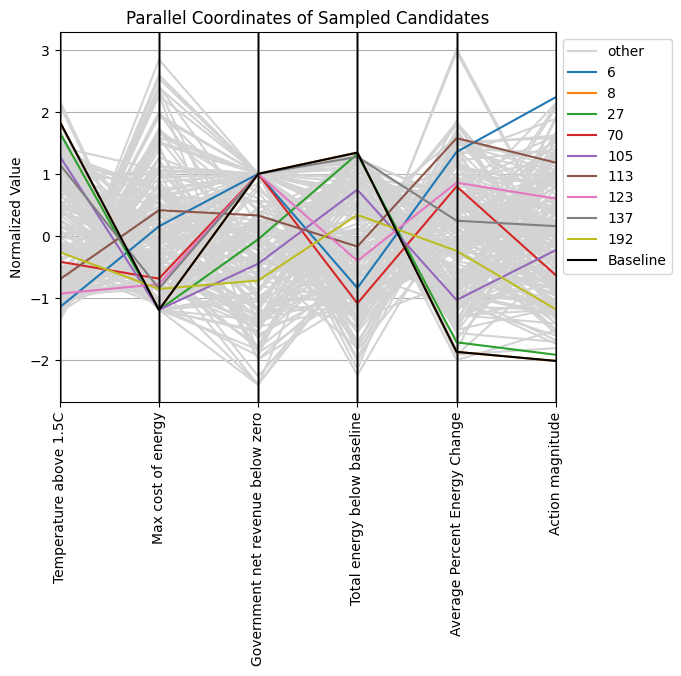

In [ ]:
plot_parallel_coordinates(F, outcomes, sample_idxs, save_path=save_path + "/parallel.png")

## Outcomes

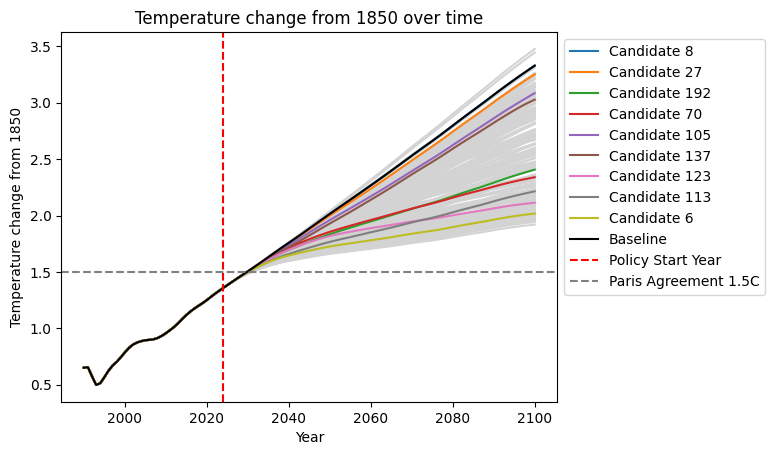

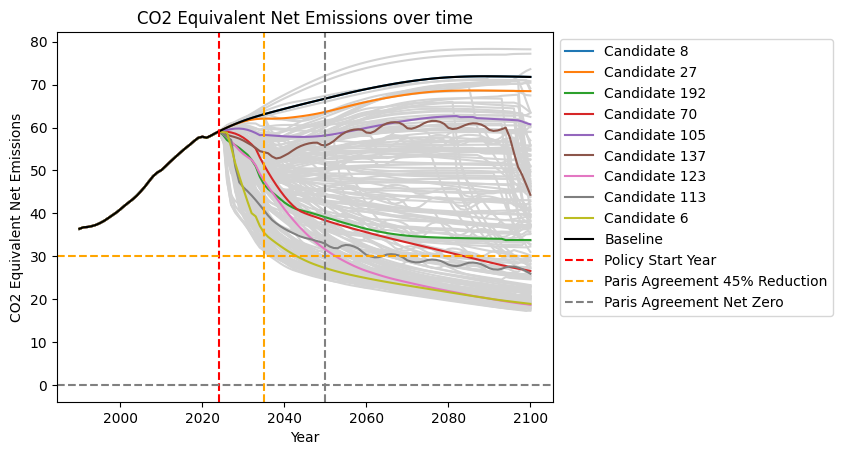

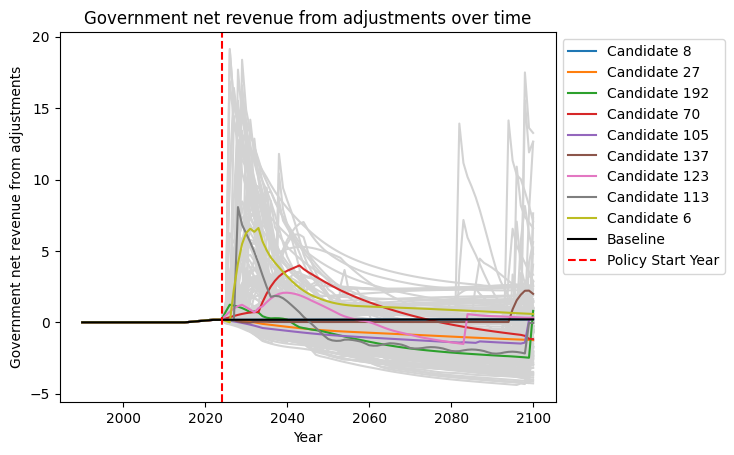

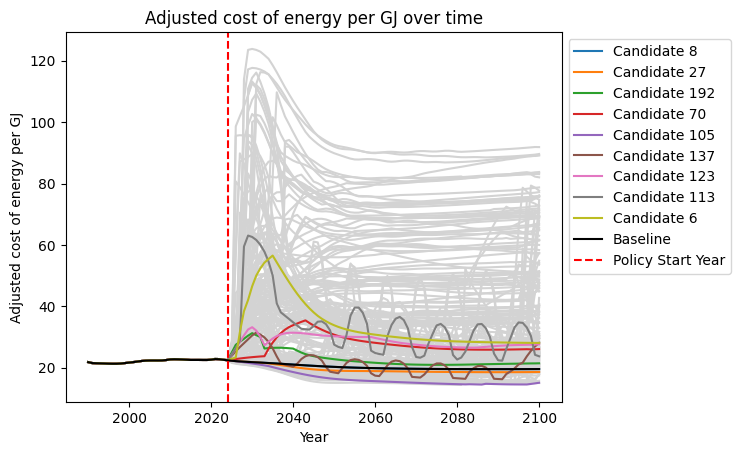

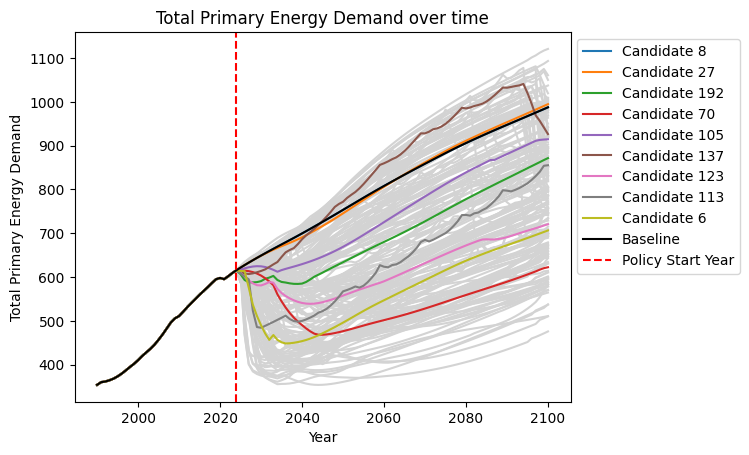

In [ ]:
def plot_outcome_over_time(outcomes: list[str], cand_idxs: list[int], X: np.ndarray, problem: EnroadsProblem, runner: EnroadsRunner, baseline_df, save_path=None):
    outcomes_dfs = []
    for cand_idx in range(X.shape[0]):
        actions_dict = problem.params_to_actions_dict(X[cand_idx])
        outcomes_df = runner.evaluate_actions(actions_dict)
        outcomes_dfs.append(outcomes_df)

    for outcome in outcomes:
        for cand_idx in range(X.shape[0]):
            if cand_idx not in cand_idxs:
                plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], color="lightgray")
        for cand_idx in cand_idxs:
            plt.plot(range(1990, 2101), outcomes_dfs[cand_idx][outcome], label=f"Candidate {cand_idx}")
        plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
        plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

        if outcome == "CO2 Equivalent Net Emissions":
            plt.axhline(y=0, color="gray", linestyle="--")
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

        elif outcome == "Temperature change from 1850":
            plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

        plt.legend(bbox_to_anchor=(1, 1))
        plt.title(f"{outcome} over time")
        plt.xlabel("Year")
        plt.ylabel(outcome)
        if save_path:
            plt.savefig(save_path + f"/{outcome.replace(' ', '-')}.png", bbox_inches='tight', dpi=300)
        plt.show()

plot_outcomes = ["Temperature change from 1850", "CO2 Equivalent Net Emissions", "Government net revenue from adjustments", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
plot_outcome_over_time(plot_outcomes, sample_idxs, X, problem, runner, baseline_df, save_path=save_path)

In [ ]:
def plot_energy_usage(cand_idxs: list[int], X: np.ndarray, problem: EnroadsProblem, runner: EnroadsRunner, baseline_df: pd.DataFrame, save_path=None):
    fig, axes = plt.subplots(1, len(cand_idxs), sharey=True, figsize=(7.5 * len(cand_idxs), 5))
    if len(cand_idxs) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_idxs, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            actions_dict = problem.params_to_actions_dict(X[cand_id])
            cand_outcomes = runner.evaluate_actions(actions_dict)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    if save_path:
        plt.savefig(save_path + "/energy.png", dpi=300)
    plt.show()

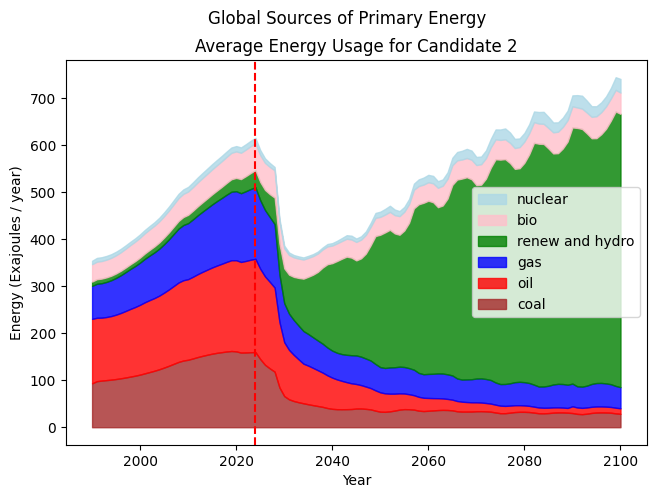

In [ ]:
plot_energy_usage([2], X, problem, runner, baseline_df)

In [ ]:
def open_idx(cand_idx: int, X: np.ndarray, problem: EnroadsProblem):
    actions_dict = problem.params_to_actions_dict(X[cand_idx])
    url = actions_to_url(actions_dict)
    webbrowser.open(url)

In [ ]:
open_idx(113, X, problem)